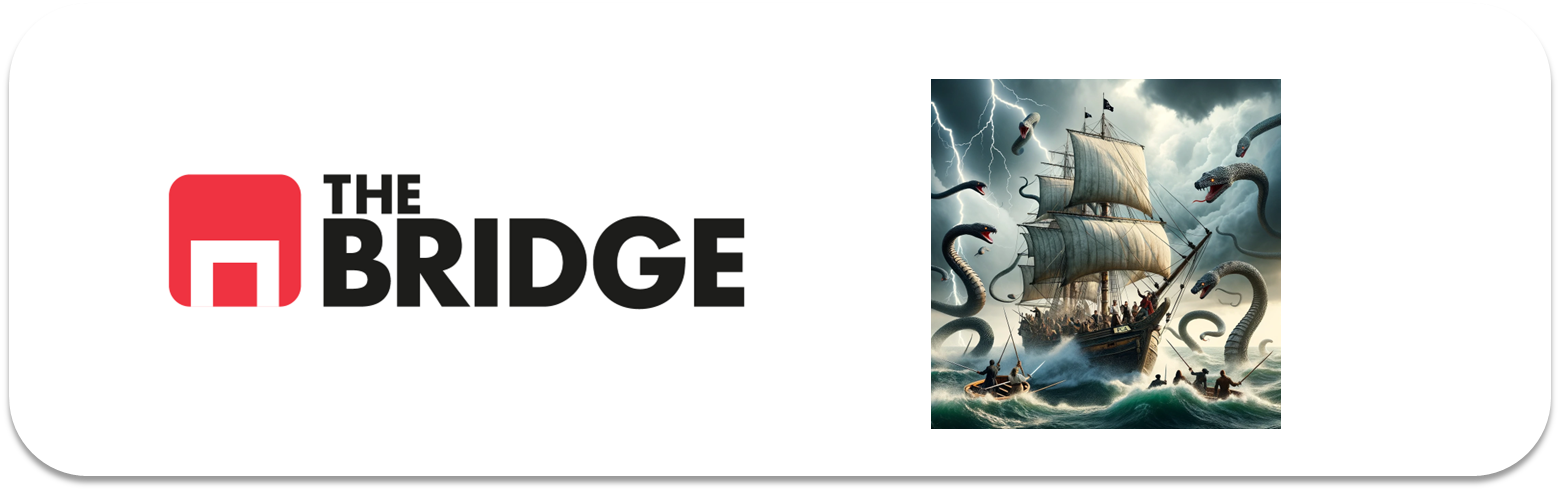

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from collections import Counter

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [5]:
df_clean = df.dropna()

In [6]:
num_vars = [
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents",
    "NumberOfOpenCreditLinesAndLoans",
]

def categorize_feature(value, bins):
    return pd.cut([value], bins=bins, labels=False)[0]

categorical_bins = {
    "NumberOfTime30-59DaysPastDueNotWorse": [0, 1, 3, float("inf")],
    "NumberOfTimes90DaysLate": [0, 1, 2, float("inf")],
    "NumberRealEstateLoansOrLines": [0, 1, 3, float("inf")],
    "NumberOfTime60-89DaysPastDueNotWorse": [0, 1, 2, float("inf")],
    "NumberOfDependents": [0, 1, 3, float("inf")],
    "NumberOfOpenCreditLinesAndLoans": [0, 5, 10, float("inf")],
}

for var, bins in categorical_bins.items():
    df_clean[var] = df_clean[var].apply(lambda x: categorize_feature(x, bins))


C:\Users\juanj\AppData\Local\Temp\ipykernel_12524\3285662236.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[var] = df_clean[var].apply(lambda x: categorize_feature(x, bins))


In [7]:
df_clean.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,NaN,0.070709,5656.0,2.0,0.0,NaN,NaN,NaN
1,0,0.023413,74,NaN,0.209197,4870.0,1.0,NaN,0.0,NaN,NaN
2,0,0.000000,43,NaN,0.080784,5000.0,0.0,NaN,NaN,NaN,1.0
3,0,0.492754,44,NaN,0.412735,7333.0,0.0,NaN,1.0,NaN,1.0
4,0,1.000000,63,NaN,0.000000,8333.0,0.0,NaN,NaN,NaN,0.0


In [9]:
def categorize_feature_fixed(series, bins):
    return np.digitize(series, bins) - 1

for var, bins in categorical_bins.items():
    df_clean[var] = categorize_feature_fixed(df_clean[var], bins)

df_clean.head()

C:\Users\juanj\AppData\Local\Temp\ipykernel_12524\2376961274.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[var] = categorize_feature_fixed(df_clean[var], bins)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,3,0.070709,5656.0,0,0,3,3,3
1,0,0.023413,74,3,0.209197,4870.0,0,3,0,3,3
2,0,0.000000,43,3,0.080784,5000.0,0,3,3,3,1
3,0,0.492754,44,3,0.412735,7333.0,0,3,1,3,1
4,0,1.000000,63,3,0.000000,8333.0,0,3,3,3,0


In [10]:
corr_matrix = df_clean.corr()

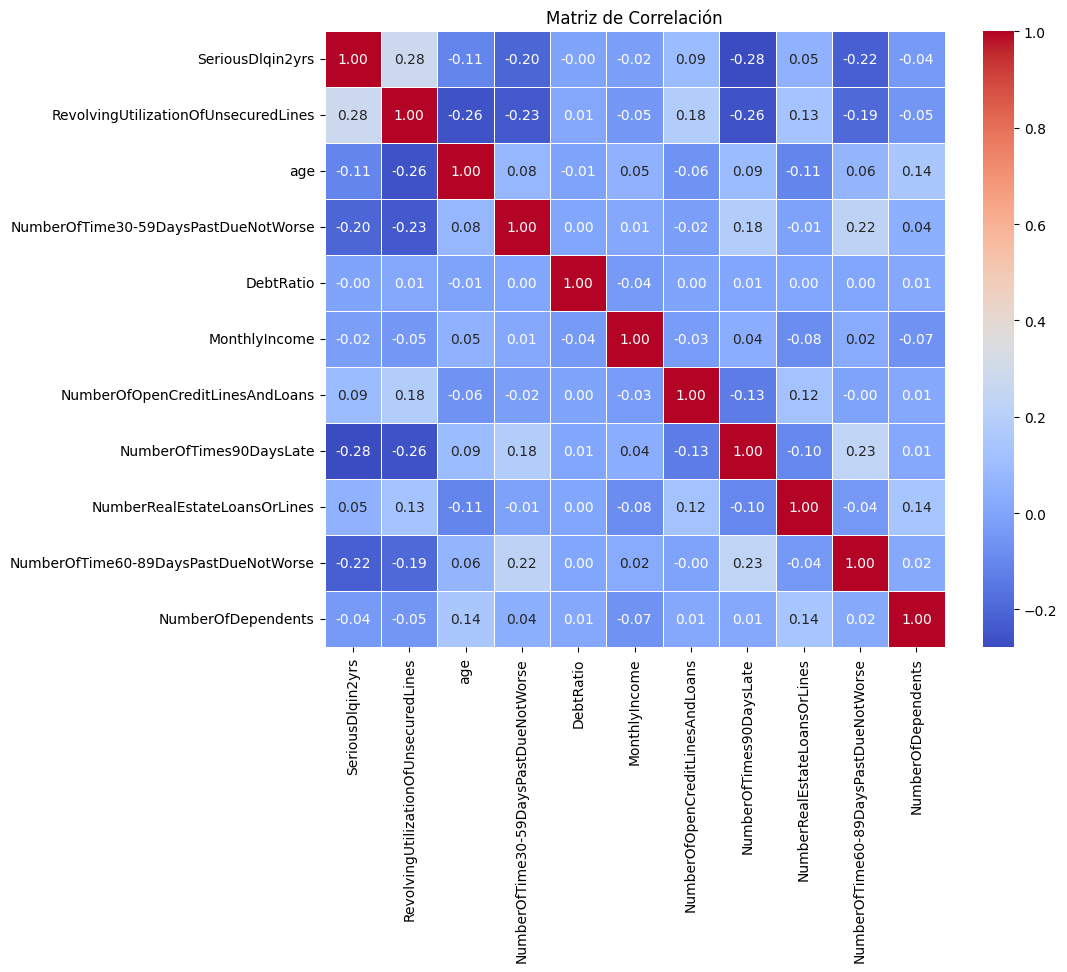

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [12]:
high_corr_features = set()
threshold = 0.75
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col] > threshold) & (corr_matrix[col] < 1.0)].tolist()
    if high_corr:
        high_corr_features.add(col)

In [13]:
# Identificar características con baja varianza
low_variance_features = df_clean.var()[df_clean.var() < 0.01].index.tolist()

# Filtrar las características relevantes eliminando las de alta correlación y baja varianza
features_to_remove = high_corr_features.union(low_variance_features)
df_filtered = df_clean.drop(columns=features_to_remove)

features_to_remove

set()

In [14]:
df_filtered

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,3,0.070709,5656.0,0,0,3,3,3
1,0,0.023413,74,3,0.209197,4870.0,0,3,0,3,3
2,0,0.000000,43,3,0.080784,5000.0,0,3,3,3,1
3,0,0.492754,44,3,0.412735,7333.0,0,3,1,3,1
4,0,1.000000,63,3,0.000000,8333.0,0,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,3,0.290216,5140.0,0,3,0,3,3
12533,0,0.036726,62,3,0.884985,5833.0,0,3,0,3,3
12534,0,0.120313,49,3,0.577676,6333.0,0,3,1,3,1
12535,0,0.252566,63,3,0.037640,14000.0,0,3,3,3,0


In [16]:
X = df_filtered.drop(columns=["SeriousDlqin2yrs"])
y = df_filtered["SeriousDlqin2yrs"]

In [17]:
num_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_features = [col for col in X.columns if col not in num_features]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
### Selección de features numéricas con SelectKBest + ANOVA
selector_num = SelectKBest(score_func=f_classif, k=6)
selector_num.fit(X_train[num_features], y_train)
best_num_features = np.array(num_features)[selector_num.get_support()].tolist()

In [21]:
cat_features = [col for col in X_train.columns if X_train[col].dtype in ["int64", "int32"]]

# Si hay variables categóricas, aplicar Mutual Information
if cat_features:
    selector_cat = SelectKBest(score_func=mutual_info_classif, k=min(6, len(cat_features)))
    selector_cat.fit(X_train[cat_features], y_train)
    best_cat_features = np.array(cat_features)[selector_cat.get_support()].tolist()
else:
    best_cat_features = []

selected_features_anova_mi = best_num_features + best_cat_features
selected_features_anova_mi


['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector_model = SelectFromModel(rf, max_features=6)
selector_model.fit(X_train, y_train)
best_model_features = X_train.columns[selector_model.get_support()].tolist()

In [23]:
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=6)
rfe.fit(X_train, y_train)
best_rfe_features = X_train.columns[rfe.get_support()].tolist()

c:\Users\juanj\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# Selección con Sequential Feature Selector (SFS)
sfs = SequentialFeatureSelector(LogisticRegression(max_iter=1000), n_features_to_select=6, direction="forward")
sfs.fit(X_train, y_train)
best_sfs_features = X_train.columns[sfs.get_support()].tolist()

In [26]:
# Contar ocurrencias de cada feature en las selecciones anteriores
feature_counts = Counter(best_num_features + best_cat_features + best_model_features + best_rfe_features + best_sfs_features)

# Seleccionar las features más votadas (mínimo en 3 métodos)
best_hard_voting_features = [feature for feature, count in feature_counts.items() if count >= 3]

In [27]:
selected_features = {
    "ANOVA + Mutual Info": selected_features_anova_mi,
    "SelectFromModel": best_model_features,
    "RFE": best_rfe_features,
    "SFS": best_sfs_features,
    "Hard Voting": best_hard_voting_features,
}

selected_features

{'ANOVA + Mutual Info': ['RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents'],
 'SelectFromModel': ['RevolvingUtilizationOfUnsecuredLines',
  'age',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfTimes90DaysLate'],
 'RFE': ['RevolvingUtilizationOfUnsecuredLines',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents'],
 'SFS': ['age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfDependents'],
 'Hard Voting': ['RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTim

In [29]:
# Modelos a probar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

results = {}

for model_name, model in models.items():
    model_results = {}
    for feature_set_name, feature_list in selected_features.items():
        if feature_list:
            X_train_subset = X_train[feature_list]
            scores = cross_val_score(model, X_train_subset, y_train, cv=5, scoring="recall")
            model_results[feature_set_name] = np.mean(scores)
    results[model_name] = model_results

results_df = pd.DataFrame(results)

In [30]:
results_df

,Logistic Regression,Random Forest,Gradient Boosting
ANOVA + Mutual Info,0.120517,0.206357,0.224413
SelectFromModel,0.100866,0.188300,0.203338
RFE,0.128025,0.249966,0.221383
SFS,0.013579,0.049692,0.016564
Hard Voting,0.119002,0.186740,0.224413


In [32]:
# Definir el mejor modelo y conjunto de features
best_model = RandomForestClassifier(random_state=42)
best_features = selected_features["RFE"]

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring="recall", n_jobs=-1)
grid_search.fit(X_train[best_features], y_train)

grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.